In [7]:
import pickle
import time
from mgmt.visualize.subject import plot_subject_with_label, plot_volume, plot_subject
import torchio as tio

import monai
from mgmt.config import get_cfg
from mgmt.data.pickle import load_subject_pickles
from mgmt.visualize.subject import plot_subject_with_label, plot_volume
import torchio as tio
import torch

from mgmt.transforms.skull_crop import SkullCropTransform

from mgmt.data.dataloader import DataModule
from mgmt.data.nifti import get_subject_folders, load_subjects

from mgmt.transforms.pad_to_min_shape import PadToMinShape

In [8]:
subjects = load_subject_pickles(
    "/home/bryan/expr/brain_tumor/preprocess-subjects-v2/resample-2.0-crop-64",
    "P-00128"
)

loading subjects from pickles: 100%|████████████████████████████████████████████████████████████| 653/653 [00:00<00:00, 3047.85it/s]


In [9]:
subject = subjects[0]

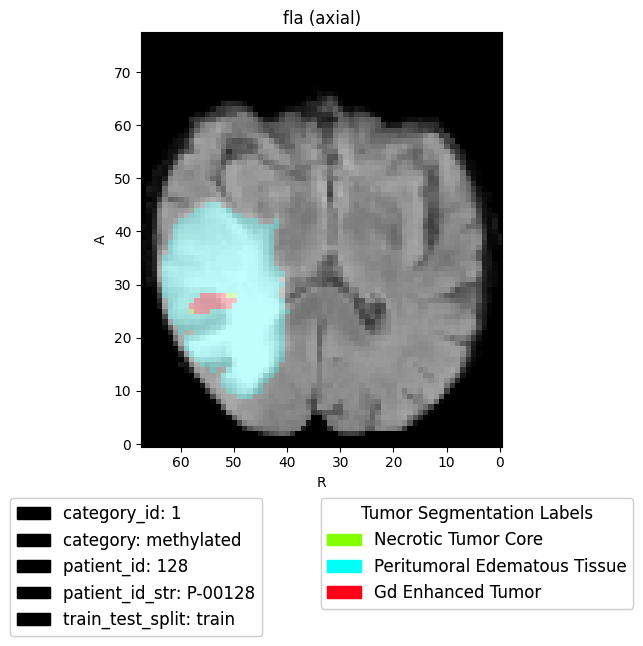

In [10]:
plot_subject_with_label(subject, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

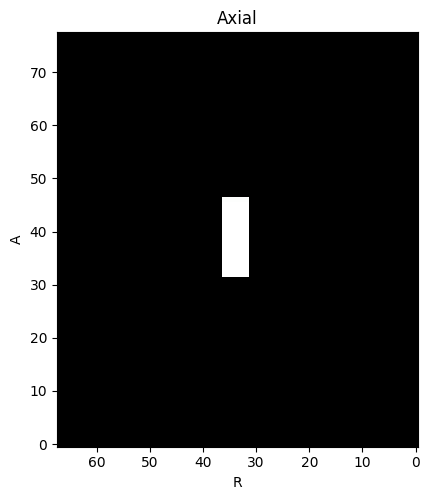

In [11]:
plot_volume(subject.patch_sampling_probability_map, show=True, single_axis="axial");

In [12]:
subject.spatial_shape

(68, 78, 70)

In [45]:
cfg = get_cfg()

In [47]:
datamodule = DataModule(cfg)
subjects = load_subjects(
    cfg.DATA.NIFTI.FOLDER_PATH,
    cfg.DATA.NIFTI.TRAIN_LABELS,
    ["fla", "t1w", "t1c", "t2w"],
    cfg.DATA.NIFTI.TEST_FOLDER_PREFIX,
)

In [48]:
subject = subjects[0]

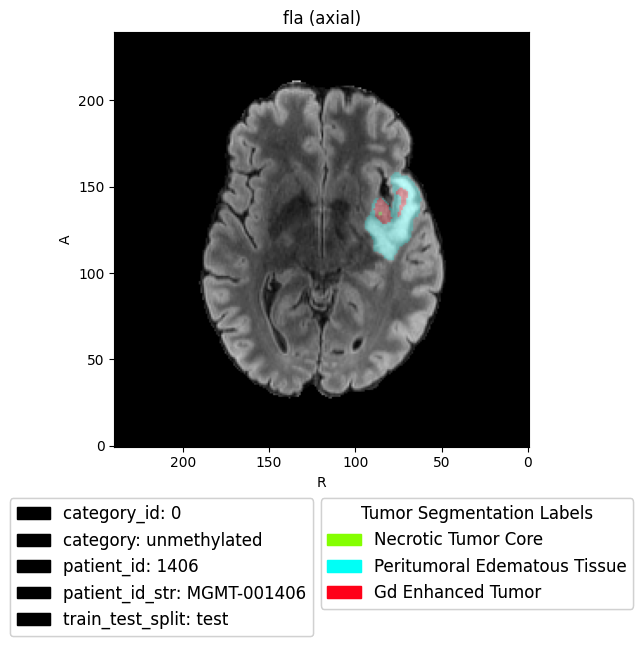

In [49]:
plot_subject_with_label(subject, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

In [52]:
subject_can = tio.ToCanonical()(subject)

In [71]:
subject_can.t1c.tensor.min()

tensor(0.)

In [72]:
subject_can.t1c.tensor.max()

tensor(17806.4668)

In [76]:
subject_resampled = tio.Resample(target=1.8, image_interpolation="linear")(subject_can)

In [77]:
subject_resampled.spatial_shape

(134, 134, 87)

In [78]:
subject_resampled.t1c.tensor.min()

tensor(0.)

In [79]:
subject_resampled.t1c.tensor.median()

tensor(0.)

In [80]:
subject_resampled.t1c.tensor.max()

tensor(17703.7598)

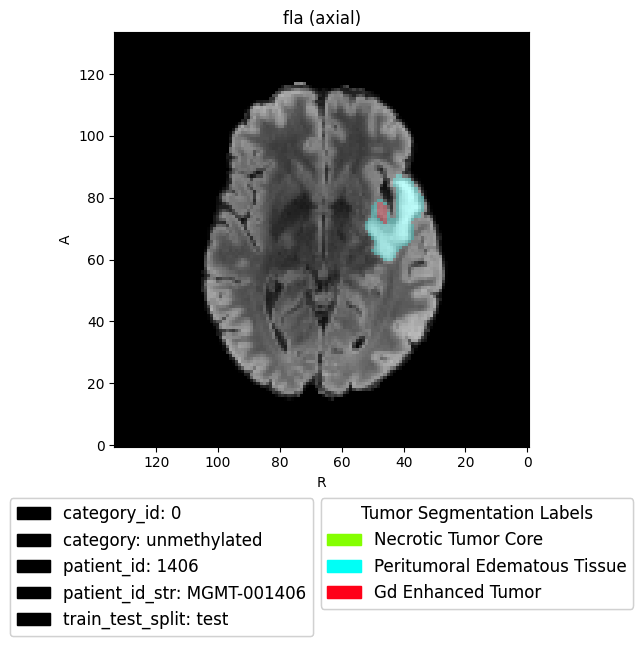

In [81]:
plot_subject_with_label(subject_resampled, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

In [82]:
subject_crop = SkullCropTransform(
    mask_image_name = "t1c",
    padding = [0, 0, 0]
)(subject_resampled)

In [83]:
subject_crop.spatial_shape

(79, 103, 79)

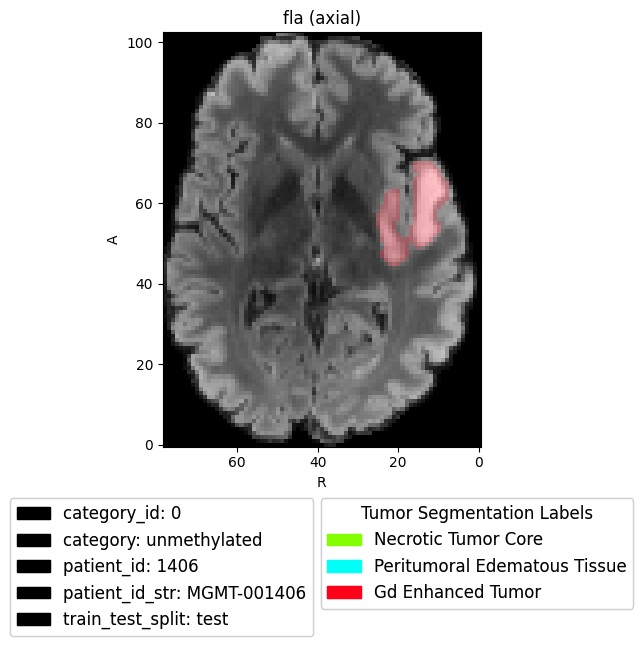

In [84]:
plot_subject_with_label(subject_crop, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

In [35]:
resample

Resample(target=1.8, image_interpolation=bspline, label_interpolation=nearest, pre_affine_name=None, scalars_only=False)

In [118]:
subject.fla.tensor.shape

torch.Size([1, 78, 100, 79])

In [120]:
min_shape = (96, 96, 96)
subject_shape = subject.spatial_shape
subject_shape

(78, 100, 79)

In [126]:
padding = []
for m,sub in zip(min_shape, subject_shape):
    pad = [0, 0]
    if sub <= m:
        diff = m - sub
        pad = [diff // 2, diff // 2 + diff % 2]
    padding.extend(pad)

In [127]:
padding

[9, 9, 0, 0, 8, 9]

In [129]:
pad_transform = PadToMinShape(min_shape=(96, 96, 96))

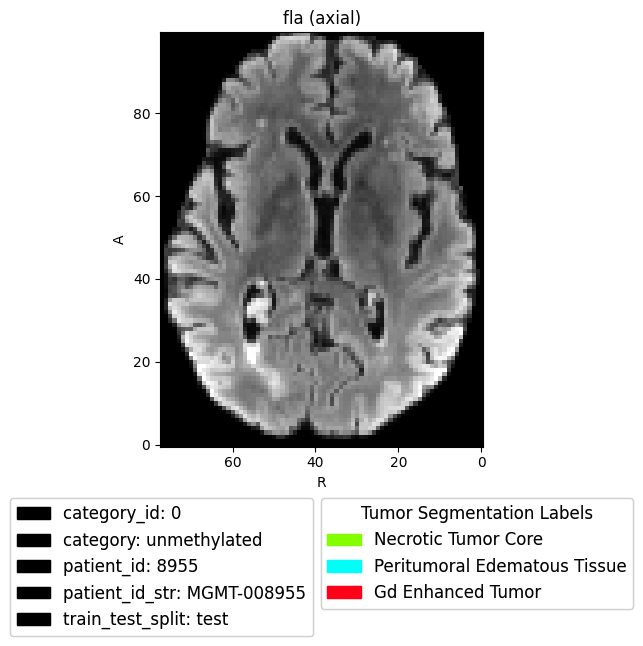

In [130]:
plot_subject_with_label(subject, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

In [131]:
subject.spatial_shape

(78, 100, 79)

In [132]:
sub_min_pad = pad_transform(subject)

In [133]:
sub_min_pad.spatial_shape

(96, 100, 96)

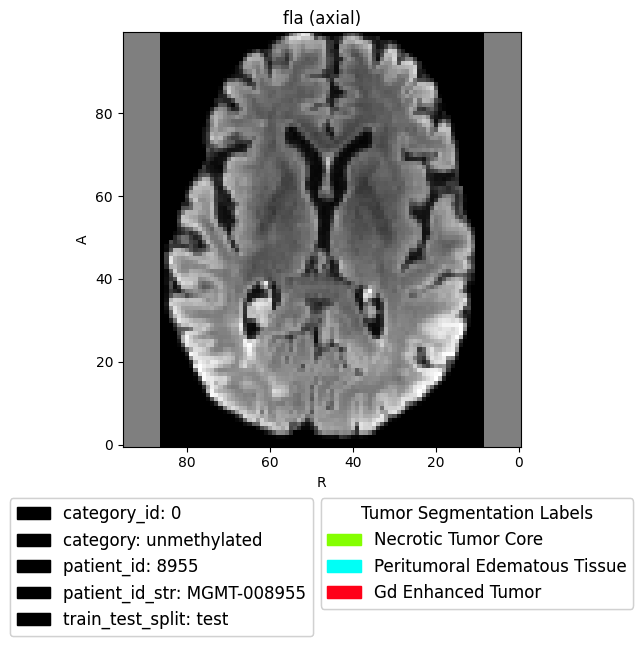

In [134]:
plot_subject_with_label(sub_min_pad, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

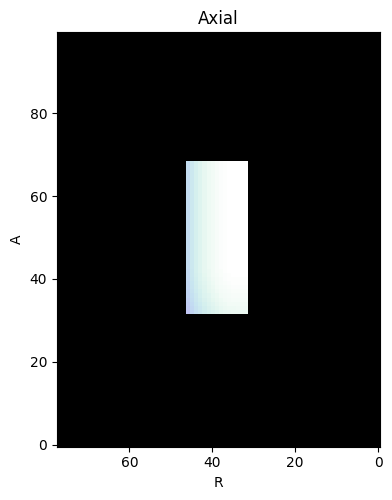

In [95]:
plot_volume(subject.patch_sampling_probability_map, show=True, single_axis="axial");

In [97]:
subject.spatial_shape

(78, 100, 79)

In [106]:
seg_mask = (subject.tumor.data > 0).type(torch.float32)

In [107]:
seg_mask = seg_mask[None, ...].to(device="cuda")

In [109]:
patch_size = [80, 80, 80]
weight = torch.ones([1, 1, *patch_size], dtype=torch.float32, device="cuda")

In [110]:
conv = torch.nn.functional.conv3d(
    seg_mask,
    weight,
    bias=None,
)

RuntimeError: Calculated padded input size per channel: (78 x 100 x 79). Kernel size: (80 x 80 x 80). Kernel size can't be greater than actual input size

In [114]:
padding = [10, 10, 20, 20, 30, 30, 0, 0]
padded = torch.nn.functional.pad(seg_mask, padding)

In [115]:
seg_mask.shape

torch.Size([1, 1, 78, 100, 79])

In [116]:
padded.shape

torch.Size([1, 1, 138, 140, 99])

In [18]:
subject.tumor.tensor > 0

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

In [20]:
import numpy as np

In [32]:
tensor = torch.tensor([0.0, 1.0, 1.2])
tensor_sig = torch.sigmoid(tensor)
print(tensor_sig)
tensor_sig.mean()

tensor([0.5000, 0.7311, 0.7685])


tensor(0.6665)

In [33]:
tensor_mean = tensor.mean()
torch.sigmoid(tensor_mean)

tensor(0.6755)

In [98]:
from dataclasses import dataclass, field, fields
from collections import defaultdict

In [101]:
@dataclass
class Predictions:
    # raw scores in range (-inf, +inf)
    logits: torch.tensor
    threshold: float = field(default=0.5)
    # score in range (0, 1.0)
    probs: torch.tensor = field(default=None)
    # binary prediction {0, 1}
    binary_preds: torch.tensor = field(init=False)
    
    def __post_init__(self):
        if self.probs is None:
            self.probs = torch.sigmoid(self.logits)
        self.binary_preds = (self.probs > self.threshold).to(torch.int64)
    
    @classmethod
    def concatenate(cls, predictions_list):
        # seq: list of predictions
        name2attr = defaultdict(list)
        for p in predictions_list:
            for field_val in fields(cls):
                p_val = getattr(p, field_val.name)
                name2attr[field_val.name].append(p_val)
        print(name2attr)
        concat = {
            k: np.concatenate(v) for k,v in name2attr.items()
        }
        return Predictions(**concat)

In [102]:
logits = torch.tensor([0.0, 1.0, 1.2])
logits2 = torch.tensor([0.0, 1.0, 1.2])
preds_list = [Predictions(logits), Predictions(logits2)]
preds_concat = Predictions.concatenate(preds_list)

defaultdict(<class 'list'>, {'logits': [tensor([0.0000, 1.0000, 1.2000]), tensor([0.0000, 1.0000, 1.2000])], 'threshold': [0.5, 0.5], 'probs': [tensor([0.5000, 0.7311, 0.7685]), tensor([0.5000, 0.7311, 0.7685])], 'binary_preds': [tensor([0, 1, 1]), tensor([0, 1, 1])]})


ValueError: zero-dimensional arrays cannot be concatenated

In [97]:
preds_cocnat

4

In [82]:
Predictions(None, probs=probs)

Predictions(logits=None, threshold=0.5, probs=tensor([0.6000, 0.7000, 0.8000]), binary_preds=tensor([1, 1, 1]))

In [74]:
A = torch.tensor([0.1, 0.2, 0.3])
B = torch.tensor([0.3, 0.5, 0.5])

In [79]:
torch.mean(torch.stack([A,B]), dim=0)

tensor([0.2000, 0.3500, 0.4000])

In [72]:
torch.mean(torch.stack([A, B]), keepdim=True)

TypeError: mean() received an invalid combination of arguments - got (Tensor, keepdim=bool), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)


In [75]:
C = torch.stack([A, B])
C.shape

torch.Size([2, 3])